In [1]:
import os
import socket
import glob
import h5py
import numpy as np
import pandas as pd
from pandas import Series, concat, cut
from datetime import datetime

import sqlite3
from sqlite3 import Error

import dask.dataframe as dd
from dask.delayed import delayed
from dask.distributed import Client

from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import yaml

from tqdm import tqdm

In [2]:
def timing_series(h5file: h5py.File, flash:int) -> Series:
    assert flash in [1, 2], "Precond.: FLASH 1 or 2"
    tGroup = h5file[f"/FL{flash:1d}/Timing/Bunch pattern/train index {flash:1d}"]
    trainId = Series(tGroup["index"], name="Train ID")
    return Series(tGroup["time"], name="Date/Time", index=trainId).apply(datetime.fromtimestamp)

def dset_series(group: h5py.Group, pos=None) -> Series:
    short_name = "/".join(group.name.split("/")[-3:])
    trainId = Series(group["index"], name="Train ID")
    if pos:
        return Series((group["value"][i][pos] for i in trainId.index), name=short_name, index=trainId)
    else:
        return Series((group["value"][i] for i in trainId.index), name=short_name, index=trainId)

def h5_load(filename, dataset_dict):
    with h5py.File(filename, 'r') as h5file:
        time = timing_series(h5file, 1)       
        dataset_list = [dset_series(h5file[value]) if type(value)==str 
                        else dset_series(h5file[value[0]],value[1]) for value in dataset_dict.values()]
        df = concat([time]+ dataset_list, axis=1).dropna()
        df.columns = ['time'] + [key for key in dataset_dict]
        return df
    
def load_dataset(file_list, dataset_dict):
    return dd.from_delayed([delayed(h5_load)(file, dataset_dict) for file in file_list])

def create_connection(db_file: str) -> sqlite3.Connection:
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
    except Error as e:
        print(e)

    return conn

def get_daq_files(id_min: int, id_max: int) -> list:
    # create a database connection
    conn = create_connection(database)
    with conn:
        sql = f'''SELECT name FROM files WHERE id IN 
            (SELECT file_id FROM trainIDs WHERE id >= {id_min} AND id <= {id_max})'''
        cur = conn.cursor()
        cur.execute(sql)
        daq_files = cur.fetchall()
    if len(daq_files) > 0:
        return [os.path.join('/asap3/fs-flash-o/gpfs/camp/2020/data/11010494/raw/hdf/express-0', i[0]) for i in daq_files]
    else:
        return
    
def get_adc_traces(id_min: int, id_max: int) -> pd.DataFrame:
    daq_files = get_daq_files(id_min, id_max)
    df = pd.DataFrame()
    for file in daq_files:
        with h5py.File(file, 'r') as f:
            df = pd.concat((df, pd.DataFrame([f[f'{ghz_adc_addr}/index'][:], f[f'{ghz_adc_addr}/value'][:]]).T), ignore_index=True)
    df.columns = ['id', 'ADC']
    df.set_index('id', inplace=True)
    df.sort_index(inplace=True)
    
    return df

In [3]:
#local_cluster = Client() 
#local_cluster

In [4]:
# get run-numbers
#with open('runs.yaml', 'r') as f:
#    runNrs = yaml.safe_load(f)
#timepix_run_number = 865
tpx_hdf = '/asap3/fs-flash-o/gpfs/camp/2020/data/11010494/processed/hdf5/e-run_0007_20200903-1517.hdf5'
database = '/asap3/fs-flash-o/gpfs/camp/2020/data/11010494/processed/hdf5/trainIDs.db'

ghz_adc_addr = '/FL1/Experiment/BL1/ADQ412 GHz ADC/CH00/TD'

#### TimePix

##### get trainIDs

In [5]:
def get_trainIDs(tpxFile):
    with h5py.File(tpxFile, 'r') as f:
        x2_trainIDs = f['timing/facility/train id'][:]
        x2_timestamps = f['timing/facility/timestamp'][:]
        tpx3_triggerNrs = f['timing/timepix/trigger nr'][:]
        tpx3_timestamps = f['timing/timepix/timestamp'][:]
    assert len(x2_trainIDs) == len(x2_timestamps), 'unmatching length'
    assert len(tpx3_triggerNrs) == len(tpx3_timestamps), 'unmatching length'
    assert len(set(x2_trainIDs)) == len(x2_trainIDs), 'found duplicates'
    assert len(set(x2_timestamps)) == len(x2_timestamps), 'found duplicates'
    assert len(set(tpx3_triggerNrs)) == len(tpx3_triggerNrs), 'found duplicates'
    assert len(set(tpx3_timestamps)) == len(tpx3_timestamps), 'found duplicates'

    start_index = np.abs(x2_timestamps - tpx3_timestamps[0]).argmin()
    print(start_index)

    #assert not (missing_elements(x2_trainIDs[start_index:])), 'list of trainIDs is not continuous'
    trainIDs = [x2_trainIDs[start_index]]
    trigger_Nrs = [tpx3_triggerNrs[0]]
    skip = 1
    for i in range(len(tpx3_triggerNrs) - 1):
        if (tpx3_triggerNrs[i + 1] - tpx3_triggerNrs[i]) == 2:
            skip += 1
        try:
            trainIDs.append(x2_trainIDs[start_index + i + skip])
            trigger_Nrs.append(tpx3_triggerNrs[i+1])
        except IndexError:
            pass
    assert len(trainIDs) == len(trigger_Nrs), 'matching fails'
    
    return (np.array(trigger_Nrs), np.array(trainIDs))

In [6]:
triggers, trainIDs_tpx = get_trainIDs(tpx_hdf)
print(len(triggers), len(trainIDs_tpx))
print(f'first ID {trainIDs_tpx.min()}, last ID {trainIDs_tpx.max()}, delta {trainIDs_tpx.max() - trainIDs_tpx.min()}')

0
3302 3302
first ID 843769210, last ID 843773822, delta 4612


In [7]:
with h5py.File(tpx_hdf, 'r') as f:
    trigNr = f['raw/trigger nr'][:]

In [8]:
_ , tpx_events = np.unique(trigNr, return_counts=True)

### FLASH's ADC

In [9]:
def sum_tof(trace, offset=10):
    if np.sum(trace) == 0:
        return -1
    trace -= np.mean(trace)
    return np.sum(trace[trace > offset])

In [10]:
%%time 
id_min = int(trainIDs_tpx[0])
id_max = int(trainIDs_tpx[-1])
adc_traces = get_adc_traces(id_min, id_min+10)

CPU times: user 586 ms, sys: 74.7 ms, total: 660 ms
Wall time: 656 ms


In [11]:
%%time
tof_sum = []
trainIDs_daq = []
for i in range(len(adc_traces)):
    trainIDs_daq.append(id_min + i)
    tof_sum.append(sum_tof(adc_traces['ADC'].iloc[i].astype(np.float)))
tof_sum = np.asarray(tof_sum)

CPU times: user 350 ms, sys: 746 µs, total: 351 ms
Wall time: 349 ms


In [12]:
'''
val, comm1, comm2 = np.intersect1d(trainIDs_daq, trainIDs_tpx-9, assume_unique=True, return_indices=True)
tof_corr = tof_sum[comm1]
tpx_corr = events[comm2]

corr2, _ = spearmanr(tof_corr, tpx_corr)
corr2
'''

'\nval, comm1, comm2 = np.intersect1d(trainIDs_daq, trainIDs_tpx-9, assume_unique=True, return_indices=True)\ntof_corr = tof_sum[comm1]\ntpx_corr = events[comm2]\n\ncorr2, _ = spearmanr(tof_corr, tpx_corr)\ncorr2\n'

In [13]:
#plt.plot(tof_corr, tpx_corr, 'o')

In [14]:
%%time

spear = []
pear = []
shift = []

for s in tqdm(range(-100,100)):
    val, comm1, comm2 = np.intersect1d(trainIDs_daq, trainIDs_tpx+s, assume_unique=True, return_indices=True)
    tof_corr = tof_sum[comm1]
    tpx_corr = tpx_events[comm2]
        
    tof_corr = np.array(tof_corr)
    tpx_corr = np.array(tpx_corr)
    corr, _  =  pearsonr(tof_corr, tpx_corr)
    corr2, _ = spearmanr(tof_corr, tpx_corr)
    pear.append(corr)
    spear.append(corr2)
    shift.append(s)
    #print(s)

100%|██████████| 200/200 [00:00<00:00, 800.07it/s]

CPU times: user 252 ms, sys: 6.4 ms, total: 258 ms
Wall time: 256 ms


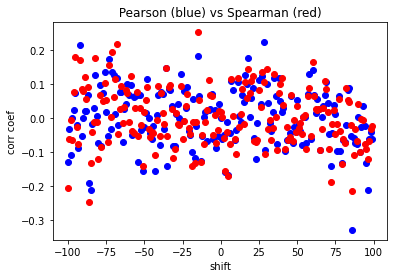

In [15]:
fig = plt.figure()
plt.plot(shift, pear,'bo')
plt.plot(shift, spear,'ro')
plt.title(f' Pearson (blue) vs Spearman (red) ')
plt.xlabel('shift')
plt.ylabel('corr coef')

pass

### check generated hdf5 file for correlation

In [16]:
#file = 'out/run_0865_20191219-0926.hdf5'

In [17]:
#with h5py.File(file, 'r') as f:
#    #f['/timing/facility'].attrs['shift'] = -9
#    print(f['/timing/facility'].attrs['shift'])